## Подготовка данных

In [1]:
import os
from analyze import *
import spacy
from spacy.matcher import Matcher

In [2]:
dataset_filename = os.path.join("..", "data", "belta_articles.json")

# Если датасет не существует – генерируем его
# if not os.path.exists(dataset_filename):
#     generate_news_dataset(filename=dataset_filename)
# else:
#     print(f"Файл {dataset_filename} уже существует. Пропускаем генерацию.")

# Загружаем данные из JSON в DataFrame
with open(dataset_filename, "r", encoding="utf-8") as f:
    data = json.load(f)
df = pd.DataFrame(data)

## Анализ текста

Общее количество статей: 7499

Статистика по длине текстов (в словах):
count    7499.000000
mean      244.969729
std       360.887528
min         1.000000
25%       113.000000
50%       173.000000
75%       260.000000
max      8751.000000
Name: text_length, dtype: float64

Статистика по длине заголовков (в словах):
count    7499.000000
mean       10.441792
std         2.474337
min         4.000000
25%         9.000000
50%        10.000000
75%        12.000000
max        21.000000
Name: title_length, dtype: float64


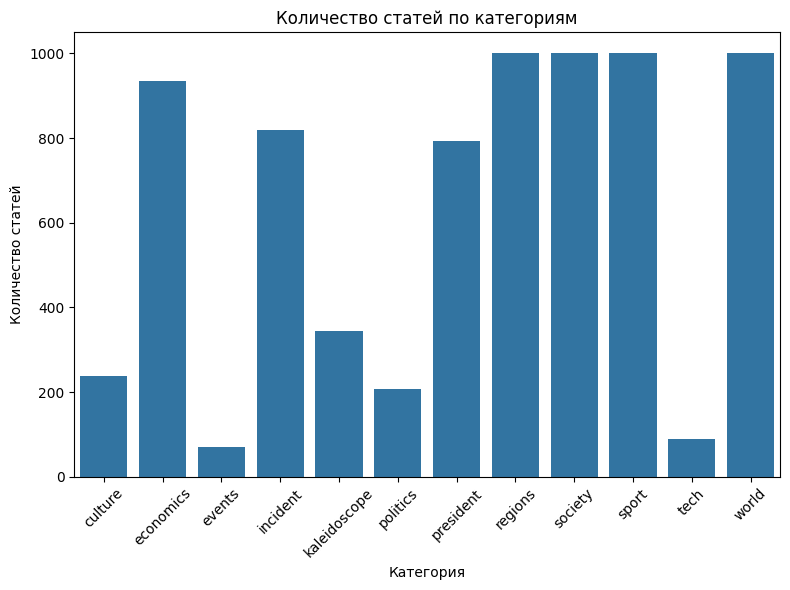

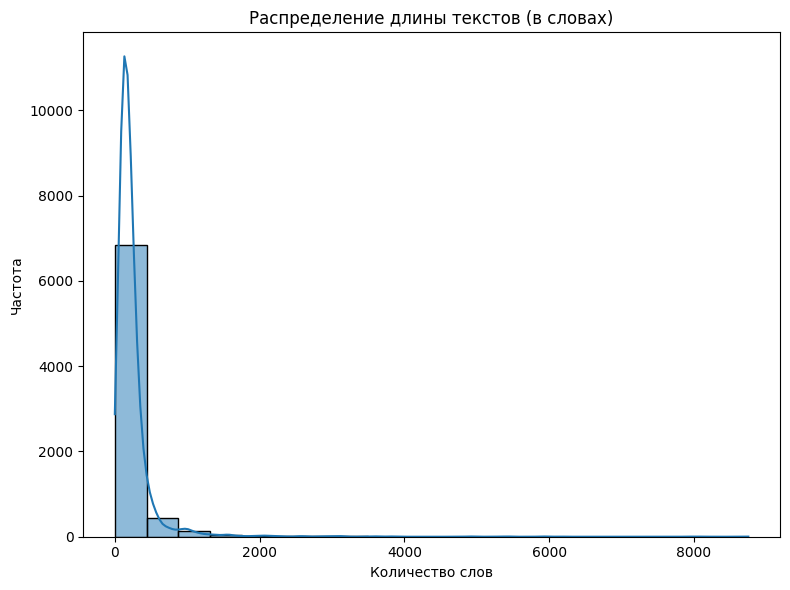

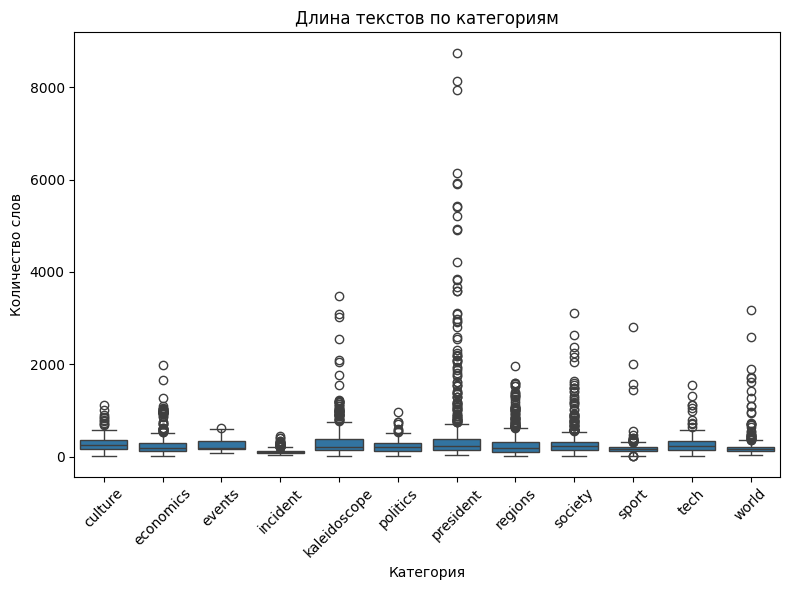

In [3]:
# Базовый анализ данных
basic_text_analysis(df)

In [4]:
# Загрузка модели spaCy (ru_core_news_sm )
# !python -m spacy download ru_core_news_sm
try:
    nlp = spacy.load("ru_core_news_sm")
    matcher = Matcher(nlp.vocab)
except Exception as e:
    print("Ошибка загрузки модели spaCy. Убедитесь, что ru_core_news_sm  установлен.")

In [5]:
# Определяем список названий месяцев на русском языке
months = ["января", "февраля", "марта", "апреля", "мая", "июня",
          "июля", "августа", "сентября", "октября", "ноября", "декабря"]

# Задаем паттерн для сопоставления шапки.
pattern = [
    {"IS_DIGIT": True},                           # день
    {"IS_SPACE": True, "OP": "+"},
    {"LOWER": {"IN": months}},                    # месяц
    {"IS_PUNCT": True, "OP": "?"},                # запятая (опционально, если не всегда)
    {"IS_SPACE": True, "OP": "*"},
    {"IS_TITLE": True, "OP": "+"},                # название города (одно или несколько слов)
    {"IS_SPACE": True, "OP": "*"},
    {"TEXT": "/", "OP": "?"},                     # слэш (начало уточняющей части)
    {"IS_ALPHA": True, "OP": "*"},                # возможный текст (например, "Корр")
    {"TEXT": ".", "OP": "?"},                     # точка после "Корр", если есть
    {"IS_ALPHA": True, "OP": "*"},                # оставшийся текст (например, "БЕЛТА")
    {"TEXT": "/", "OP": "?"}                      # закрывающий слэш
]

matcher.add("HEADER", [pattern])

In [6]:
def remove_header_spacy(text):
    doc = nlp(text)
    matches = matcher(doc)
    if matches:
        # Проверяем, начинается ли первый матч с первого токена (т.е. шапка в начале)
        match_id, start, end = matches[0]
        if start == 0:
            # Возвращаем текст, начиная с токена после найденного паттерна
            return doc[end:].text.lstrip()
    return text  # если паттерн не найден, возвращаем исходный текст

In [ ]:
# Чистим шапку
df["text"] = df["text"].apply(remove_header_spacy)

In [ ]:
print("\nПредобработка текстов (токенизация, лемматизация, удаление стоп-слов и пунктуации)...")
processed_texts = preprocess_texts(df["text"], nlp)

# Анализ ключевых слов по категориям
analyze_keywords_by_category(df, processed_texts)

## Выводы